# Basic Exploration of REVISE outputs

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from collections import namedtuple
from functools import partial

from jax import random, jit
from jax.experimental.stax import Relu, Sigmoid, Elu, Selu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from jax_nn import create_mlp, binary_crossentropy_loss
from jax_vae import create_vae
from revise import Revise

In [25]:
rng_key = random.PRNGKey(0)

## Generate Data

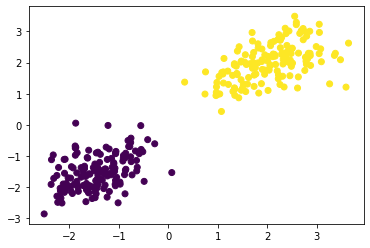

In [26]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

np.random.seed(0)
indices = np.random.randint(2, size=300)
samples = [
    np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + 
           np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) 
           for i in indices]

x_train = np.array(samples)
_ = plt.scatter(x_train[:, 0], x_train[:, 1], c=indices)

## Construct Encoder, Decoder, VAE

We're not using classes for these implementations. We've written everything in JAX, so everything is done in a more functional style. This means functions are pure and state is only carried through by partial function application. Classes are replaced by named tuples, which can provide a similar interface but are immutable so state is easier to manage. (We just learned JAX, so there are still some minor memory leaks and things could likely be sped up a lot.)

In [27]:
data = x_train
data_vari = x_var

latent_dim = 2

enc_params = {
    'input_dim': 2,
    'hidden_widths': [64, 64],
    'activation_fn': Relu,
    'output_dim': latent_dim * 2
}
dec_params = {
    'input_dim': 2,
    'hidden_widths': [64, 64],
    'activation_fn': Relu,
    'output_dim': 2
}

vae = create_vae(rng_key, enc_params, dec_params)
vae, loss_history = vae.fit(rng_key, data, data_vari, step_size=1e-2, max_iter=500)

In [28]:
min(loss_history)

2.557772159576416

<AxesSubplot:>

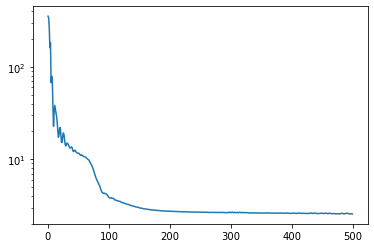

In [29]:
pd.Series(loss_history).plot.line(logy=True)

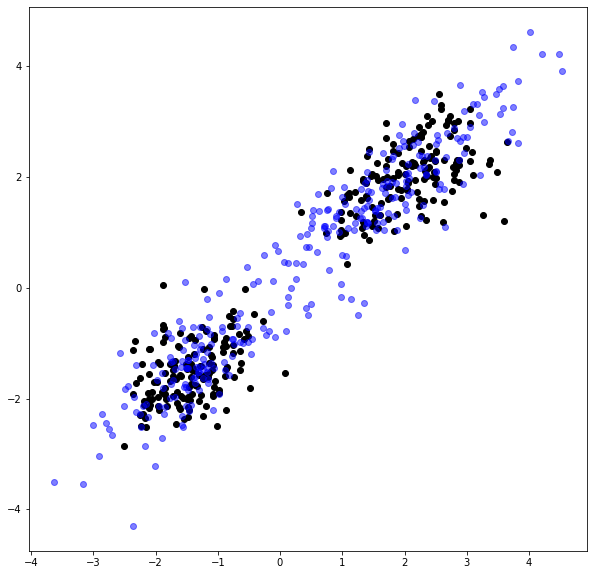

In [30]:
x_hat = vae.generate(rng_key, n=300)
x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x_train.T[0], x_train.T[1], color='black')
ax.scatter(x_hat[:,0], x_hat[:,1], color='blue', alpha=0.5)

## Build the Classifier

In [31]:
data = (x_train, indices.reshape(-1, 1))

input_dim = 2
hidden_widths = [100]
hidden_activation = Relu
output_dim = 1
output_activation = Sigmoid

classifier = create_mlp(
    rng_key, input_dim, hidden_widths, hidden_activation, output_dim, output_activation)
classifier, history = classifier.fit(binary_crossentropy_loss, data, step_size=1e-2, max_iter=200)

<AxesSubplot:>

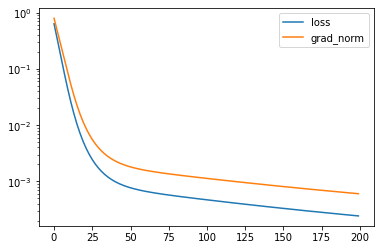

In [32]:
pd.DataFrame(history, columns=['loss', 'grad_norm']).plot.line(logy=True)

### Look at Predictions

In [33]:
preds = classifier.predict(x_train) > 0.5

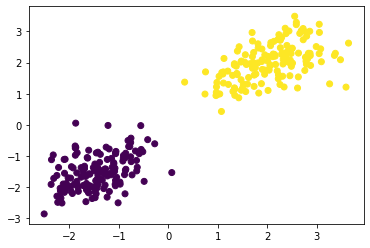

In [34]:
plt.scatter(x_train[:,0], x_train[:,1], c=indices)

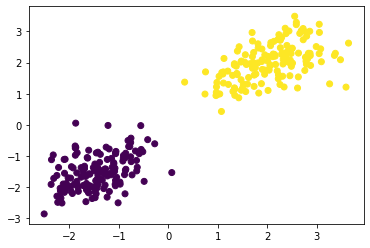

In [35]:
plt.scatter(x_train[:,0], x_train[:,1], c=preds)

## Pick a Point for Recourse

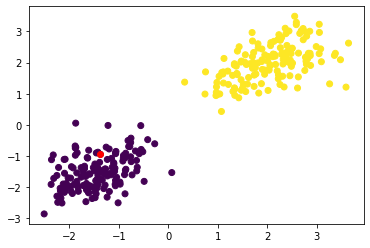

In [36]:
chosen_point = x_train[3]
plt.scatter(x_train[:,0], x_train[:,1], c=indices)
plt.scatter(*chosen_point.T, color='red')

## Run REVISE and Generate Graphs

In [37]:
revisor = Revise(classifier, vae)

In [38]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-3, max_iter=500)

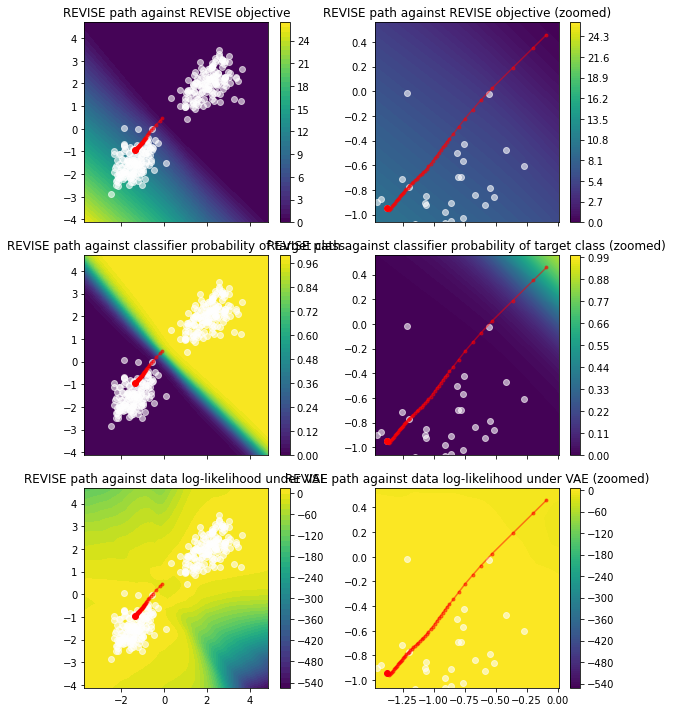

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex='col', sharey=False)
revisor.show_path(path, x_train, ax=axes[0][0], fig=fig)
revisor.show_path(path, x_train, ax=axes[0][1], fig=fig, zoom=True)
revisor.show_path(path, x_train, ax=axes[1][0], fig=fig, landscape='prob_target')
revisor.show_path(path, x_train, ax=axes[1][1], fig=fig, landscape='prob_target', zoom=True)
revisor.show_path(path, x_train, ax=axes[2][0], fig=fig, landscape='likelihood')
revisor.show_path(path, x_train, ax=axes[2][1], fig=fig, landscape='likelihood', zoom=True)
fig.tight_layout()